In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [2]:
def remove_duplicates(lst):
    seen = set()
    result = []
    for x in lst:
        if x not in seen:   
            seen.add(x)
            result.append(x)
    return result


In [3]:
# build function for each scenario 
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(-1, 1))
m1.x1 = Var(bounds=(0, 1))
m1.c1 = Constraint(expr=m1.x1**4 == m1.y**2)
m1.obj = Objective(expr= -m1.x1, sense=minimize)

m2 = ConcreteModel()
m2.y = Var(bounds=(-1, 1))
m2.x2 = Var(bounds=(0, 1))
m2.c1 = Constraint(expr=m2.x2**2 >= m2.y)
m2.c2 = Constraint(expr=m2.x2**2 >= -m2.y)
m2.obj = Objective(expr=m2.x2, sense=minimize)

model_list = [m1, m2]

In [4]:
def compute_piecewise_hausdorff(delta, v_list, model_list, add_node_num=0, n_samples=5, tolerance=1e-10):
    """
    Parameters:
        delta (float): range of variable
        n_samples (float): number of sample nodes
        v_list (list): list of scenario functions  
        model: model with submodels corresponds to each scenario
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list)
    y_nodes = np.linspace(-delta, delta, n_samples).tolist()
    lst = np.ones(N).tolist() 
    y_opt_list = np.ones(N).tolist() 
    as_nodes_list = np.ones(N).tolist() 
    ms_list = np.ones(N).tolist() 
    
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(-delta)
        model_list[i].y.setub(delta)
    
    for _ in range(add_node_num+1):
        if y_opt_list != lst:
            # check if new nodes are already in y_nodes
            for new_y in y_opt_list:
                if new_y in y_opt_list:
                    print("QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is")
                    print(new_y)

            for j in range(len(y_opt_list)):
                bisect.insort(y_nodes, y_opt_list[j])
            # delete repeated nodes
            #y_nodes = list(dict.fromkeys(y_nodes))
            y_nodes = remove_duplicates(y_nodes)

        for i in range(N):
            as_nodes_list[i] = [v_list[i](y) for y in y_nodes]
        
        # define piecewise function for each scenario
        for i in range(N):
            if hasattr(model_list[i], 'As'):
                model_list[i].del_component('As')
            if hasattr(model_list[i], 'pw'):
                model_list[i].del_component('pw')
            #model_list[i].del_component('y')
            #model_list[i].y = Var(bounds=(-delta, delta))
            
            
            
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='INC'
            )

        # start to solve the submodels
        solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
        solver.options['numerics/feastol'] = tolerance
        solver.options['numerics/dualfeastol'] = tolerance
        solver.options['limits/gap'] = tolerance
     
        for i in range(N):
            old_expr = model_list[i].obj.expr
            model_list[i].del_component('obj')
            model_list[i].obj = Objective(expr=old_expr - model_list[i].As, sense=minimize)
            #solver.solve(model_list[i])
            # get the ms value
            #ms_list[i] = value(model_list[i].obj2)
            results = solver.solve(model_list[i])
            ms_list[i] = results.problem.lower_bound

            
            y_opt_list[i] = value(model_list[i].y)
            as_nodes_list[i] = [v_list[i](y) for y in y_nodes]
    
    
    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0).tolist()
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(-delta, delta))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=assum_nodes,
        pw_constr_type='EQ',
        pw_repn='INC'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
    solver.options['numerics/feastol'] = tolerance
    solver.options['numerics/dualfeastol'] = tolerance
    solver.options['limits/gap'] = tolerance
    solver.solve(model_sum)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("bad bad bad")
    # get the output
    errors = value(model_sum.obj) + sum(ms_list)
    errors = -errors
    
    #return delta, errors, 1, 2  # diameter, error
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], y_opt_list[0]

In [ ]:
if (results.solver.status == SolverStatus.ok) and \
   (results.solver.termination_condition == TerminationCondition.optimal):
    print("✅ Optimal solution found!")
    
    # 7. 打印目标函数值
    print("Objective value:", value(model.obj))

    # 8. 打印变量取值
    for v in model.component_objects(Var, active=True):
        print(f"Variable block: {v}")
        varobject = getattr(model, str(v))
        for index in varobject:
            print(f"  {index}: {varobject[index].value}")
    
    # 9. 打印上下界（如果 solver 支持）
    if hasattr(results.problem, 'lower_bound'):
        print("Lower bound:", results.problem.lower_bound)
    if hasattr(results.problem, 'upper_bound'):
        print("Upper bound:", results.problem.upper_bound)

else:
    print("❌ No optimal solution found.")
    print("Status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)


In [5]:
# make delta list
##deltas = np.array([1, 1e-1, 1e-2,1e-03, 1e-4, 1e-5])
#adds = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
adds = np.array([0, 1, 2, 3, 4, 5, 6, 7])
d = 1
results = [compute_piecewise_hausdorff(d,v_list,model_list,a) for a in adds]

**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-0.12500000001080547
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-1.0
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help document

model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-0.12500000001080547
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-1.0
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-0.12500000001080547
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-1.0
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
QQQQQQQQQQQQQQ

QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-0.12500000001080547
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-1.0
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-0.12500000001080547
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-1.0
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible or unbounded
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-0.12500000001080547
QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQFINDISSUE,repeated y is
-1.0
model.name="unknown";
    - termination condition: infeasible
    - message from solve

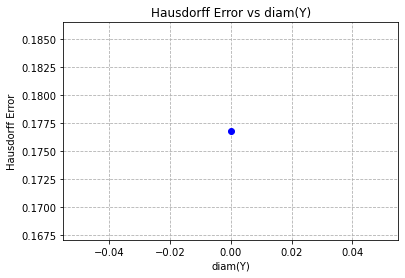

add_nodes 	    error
0.000	0.176776695325564
1.000	inf
2.000	inf
3.000	inf
4.000	inf
5.000	inf
6.000	inf
7.000	inf
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
0
[-1.  -0.5  0.   0.5  1. ]
5
ms value
-0.176776695325564
y_opt value
-0.12500000001080547
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
1
[-1.    -0.5   -0.125  0.     0.5    1.   ]
6
ms value
-inf
y_opt value
-0.12500000001080547
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
2
[-1.    -0.5   -0.125  0.     0.5    1.   ]
6
ms value
-inf
y_opt value
-0.12500000001080547
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
3
[-1.    -0.5   -0.125  0.     0.5    1.   ]
6
ms value
-inf
y_opt value
-0.12500000001080547
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
4
[-1.    -0.5   -0.125  0.     0.5    1.   ]
6
ms value
-inf
y_opt value
-0.12500000001080547
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
5
[-1.    -0.5   -0.125  0.     0.5    1.   ]
6
ms value
-inf
y_opt value
-0.12500000001080547
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
6
[-1.    -0.5   -0.125  0.     0.5    1.   ]
6
ms value
-i

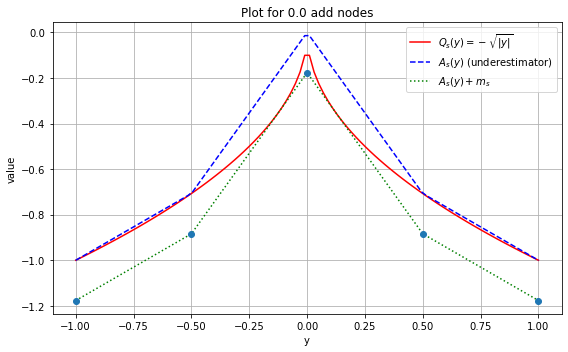

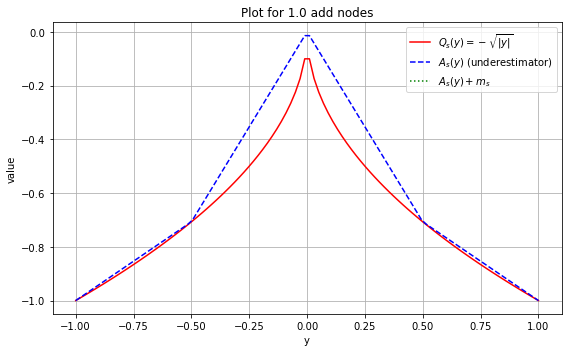

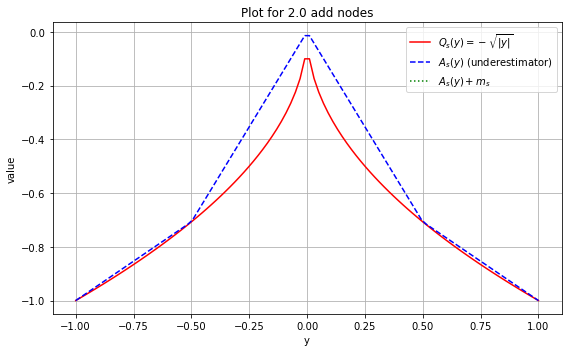

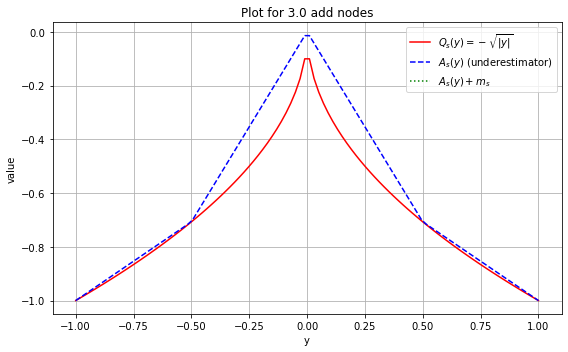

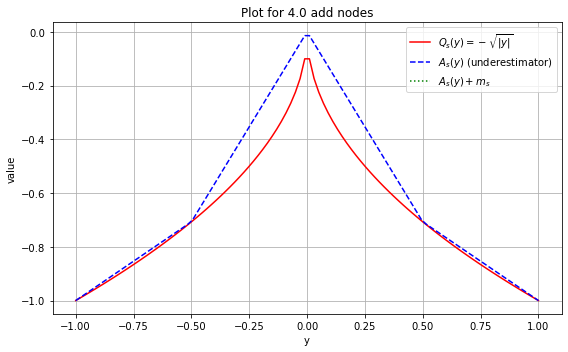

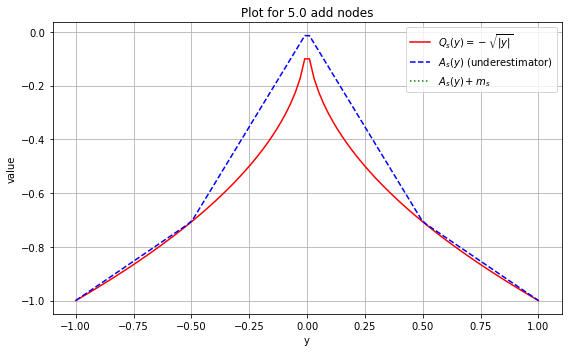

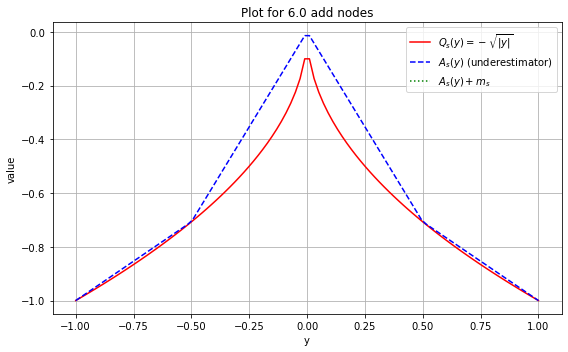

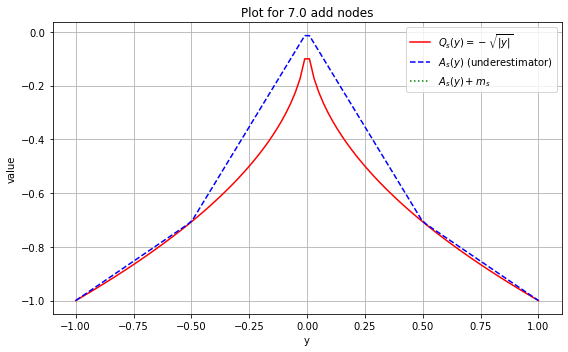

In [6]:
# make the plot
plt.figure()
#diameters, errors = zip(*results)
diameters, errors = zip(*[(r[0], r[1]) for r in results])

plt.plot(adds, errors, marker='o', color='blue')
plt.xlabel("diam(Y)")
plt.ylabel("Hausdorff Error")
plt.title("Hausdorff Error vs diam(Y)")
plt.grid(True, which="both", ls="--")
plt.show()

print("add_nodes \t    error")
for i in range(len(errors)):
    print(f"{adds[i]:.3f}\t{errors[i]:.15f}")
    


for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(-d, d, 100)
    z_vals = np.abs(y_vals)

    # define Qs(y)
    Qs_vals2 = -np.sqrt(z_vals)

    # As(y)
    y_nodes = np.array(results[i][2])
    print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
    print(i)
    print(y_nodes)
    print(len(y_nodes))
    print("ms value")
    print(results[i][4])
    print("y_opt value")
    print(results[i][5])
    z_nodes = abs(y_nodes)
    #as_nodes = np.sqrt(z_nodes)
    as_nodes = np.array(results[i][3])
    As_vals2 = np.interp(z_vals, y_nodes, as_nodes)
    As_shifted_vals2 = As_vals2 + results[i][4]

    # make the plot
    plt.figure(figsize=(8, 5))
    plt.plot(y_vals, Qs_vals2, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
    plt.plot(y_vals, As_vals2, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
    plt.plot(y_vals, As_shifted_vals2, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
    plt.plot(y_nodes, as_nodes+results[i][4], 'o')
    plt.xlabel('y')
    plt.ylabel('value')
    #plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
    plt.title(f"Plot for {i:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.show()

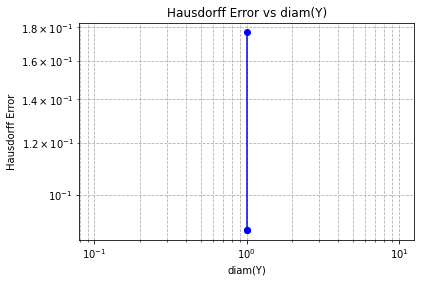

delta 	    error


ValueError: too many values to unpack (expected 2)

In [78]:
# make the plot
plt.figure()
#diameters, errors = zip(*results)
diameters, errors = zip(*[(r[0], r[1]) for r in results])

plt.loglog(diameters, errors, marker='o', color='blue')
plt.xlabel("diam(Y)")
plt.ylabel("Hausdorff Error")
plt.title("Hausdorff Error vs diam(Y)")
plt.grid(True, which="both", ls="--")
plt.show()

print("delta \t    error")
for a, b in results:
    print(f"{a:.6f}\t{b:.15f}")

In [59]:
# make the plot
plt.figure()
#diameters, errors = zip(*results)
diameters, errors = zip(*[(r[0], r[1]) for r in results])

plt.loglog(diameters, errors, marker='o', color='blue')
plt.xlabel("diam(Y)")
plt.ylabel("Hausdorff Error")
plt.title("Hausdorff Error vs diam(Y)")
plt.grid(True, which="both", ls="--")
plt.show()

print("delta \t    error")
for a, b in results:
    print(f"{a:.6f}\t{b:.15f}")
    



for i in range(3):
    # y and z = |y|
    y_vals = np.linspace(-diameters[i], diameters[i], 100)
    z_vals = np.abs(y_vals)

    # define Qs(y)
    Qs_vals2 = np.sqrt(z_vals)

    # As(y)
    y_nodes = np.array(aaa[i])
    z_nodes = abs(y_nodes)
    as_nodes = np.sqrt(z_nodes)
    As_vals2 = np.interp(z_vals, y_nodes, as_nodes)
    As_shifted_vals2 = As_vals2 + bbb[i]

    # make the plot
    plt.figure(figsize=(8, 5))
    plt.plot(y_vals, Qs_vals2, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
    plt.plot(y_vals, As_vals2, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
    plt.plot(y_vals, As_shifted_vals2, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.show()

ValueError: too many values to unpack (expected 4)

<Figure size 432x288 with 0 Axes>

'pyomo.core.base.var.ScalarVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.piecewise.SimplePiecewise'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.piecewise.SimplePiecewise'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.var.ScalarVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.piecewise.SimplePiecewise'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.piecewise.SimplePiecewise'>). This is
usually indicative of a modelling error. To avoid this warning, use
block

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.var.ScalarVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.piecewise.SimplePiecewise'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.piecewise.SimplePiecewise'>). This is
usually indicative of a modelling error. To avoid this wa

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.var.ScalarVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.piecewise.SimplePiecewise'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.piecewise.SimplePiecewise'>). This is
usually indicative of a modelling error. To avoid this wa

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.var.ScalarVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.piecewise.SimplePiecewise'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.piecewise.SimplePiecewise'>). This is
usually indicative of a modelling error. To avoid this wa

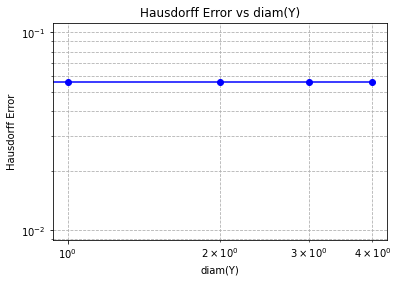

delta 	    error
0.100000	0.055901713663221
0.100000	0.055901713663221
0.100000	0.055901713663221
0.100000	0.055901713663221
0.100000	0.055901713663221


In [32]:
# make delta list
#deltas = np.array([1, 1e-1, 1e-2,1e-03, 1e-4, 1e-5])
its = np.array([0,1,2,3,4])
results = [compute_piecewise_hausdorff(0.1,v_list,model_list,d,5,1e-10) for d in its]

# make the plot
diameters, errors = zip(*results)
plt.loglog(its, errors, marker='o', color='blue')
plt.xlabel("diam(Y)")
plt.ylabel("Hausdorff Error")
plt.title("Hausdorff Error vs diam(Y)")
plt.grid(True, which="both", ls="--")
plt.show()

print("delta \t    error")
for a, b in results:
    print(f"{a:.6f}\t{b:.15f}")

**WARNING: Piecewise component 'pw3[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'pw3[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'pw3[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'pw3[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
**WARNING: Piecewise component 'pw3[(None,)]' has detected slopes of consecutive piecewise segments 

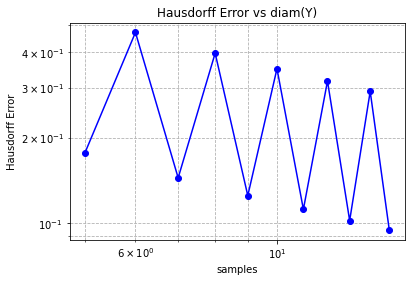

delta 	    error
1.000000	0.176776720764951
1.000000	0.469144111976009
1.000000	0.144337658587362
1.000000	0.396499147876172
1.000000	0.125000079453145
1.000000	0.349679380522178
1.000000	0.111803506425908
1.000000	0.316296924270163
1.000000	0.102062104534555
1.000000	0.290950863023780
1.000000	0.094491255798852


In [132]:
samples = np.array([5,6,7,8,9,10,11,12,13,14,15])
results = [compute_piecewise_hausdorff(1,s) for s in samples]

# make the plot
delta, errors = zip(*results)
plt.loglog(samples, errors, marker='o', color='blue')
plt.xlabel("samples")
plt.ylabel("Hausdorff Error")
plt.title("Hausdorff Error vs diam(Y)")
plt.grid(True, which="both", ls="--")
plt.show()

print("delta \t    error")
for a, b in results:
    print(f"{a:.6f}\t{b:.15f}")

# check 1e-03

In [135]:
# define basic things
delta = 1e-04
n_samples = 5

y_nodes = np.linspace(-delta, delta, n_samples).tolist()
as_nodes = [-np.sqrt(abs(y)) for y in y_nodes]

# create model
model = ConcreteModel()
model.x1 = Var(bounds=(0, 1))
model.y = Var(bounds=(-delta, delta))

# define piecewise function
model.As = Var()
model.pw = Piecewise(
    model.As, model.y,
    pw_pts=y_nodes,
    f_rule=as_nodes,
    pw_constr_type='EQ',
    pw_repn='INC'
)

# set up constraint
model.eq = Constraint(expr=model.x1**4 == model.y**2)

# define objective function and solve the model
model.obj = Objective(expr= -model.x1 - model.As, sense=minimize)
solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
aa = 1e-9
solver.options['numerics/feastol'] = aa
solver.options['numerics/dualfeastol'] = aa
solver.options['limits/gap'] = aa
solver.solve(model)

# print the output
x1_opt = value(model.x1)
y_opt = value(model.y)
as_val = value(model.As)
m_s1 = value(model.obj)
print(f"x1 = {x1_opt:.4f}, y = {y_opt:.4f}, A_s(y) = {as_val:.4f}, m_s = {m_s1:.4f}")

x1 = 0.0052, y = 0.0000, A_s(y) = 0.0000, m_s = -0.0052


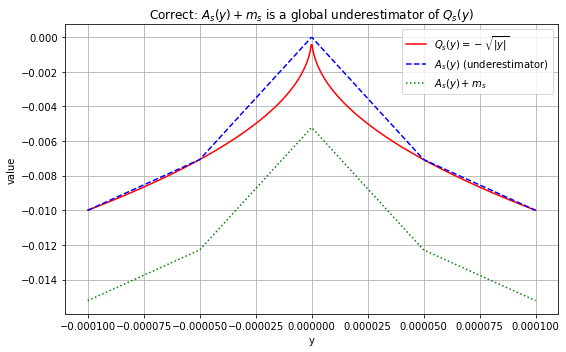

In [136]:
# y and z = |y|
y_vals = np.linspace(-delta, delta, 500)
z_vals = np.abs(y_vals)

# define Qs(y)
Qs_vals1 = -np.sqrt(z_vals)

# As(y)
y_nodes = np.array(y_nodes)
z_nodes = abs(y_nodes)
as_nodes = -np.sqrt(z_nodes)
As_vals1 = np.interp(z_vals, y_nodes, as_nodes)
# As + ms
As_shifted_vals1 = As_vals1 + m_s1

# make the plot
plt.figure(figsize=(8, 5))
plt.plot(y_vals, Qs_vals1, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, As_vals1, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
plt.plot(y_vals, As_shifted_vals1, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# define sampling nodes
y_nodes = np.linspace(-delta, delta, n_samples).tolist()
as_nodes = [np.sqrt(abs(y)) for y in y_nodes]


# define model
model = ConcreteModel()
model.x2 = Var(bounds=(0, 1))
model.y = Var(bounds=(-delta, delta))

# define piecewise function
model.As = Var()
model.pw = Piecewise(
    model.As, model.y,
    pw_pts=y_nodes,
    f_rule=as_nodes,
    pw_constr_type='EQ',
    pw_repn='INC'
)

# set up constraint
model.c1 = Constraint(expr=model.x2**2 >= model.y)
model.c2 = Constraint(expr=model.x2**2 >= -model.y)

# define objective function and solve the model
model.obj = Objective(expr=model.x2 - model.As, sense=minimize)
solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
solver.solve(model)

# print the output
x2_opt = value(model.x2)
y_opt = value(model.y)
as_val = value(model.As)
m_s2 = value(model.obj)
print(f"x2 = {x2_opt:.4f}, y = {y_opt:.4f}, A_s(y) = {as_val:.4f}, m_s = {m_s2:.4f}")

x2 = 0.0223, y = 0.0005, A_s(y) = 0.0224, m_s = -0.0000


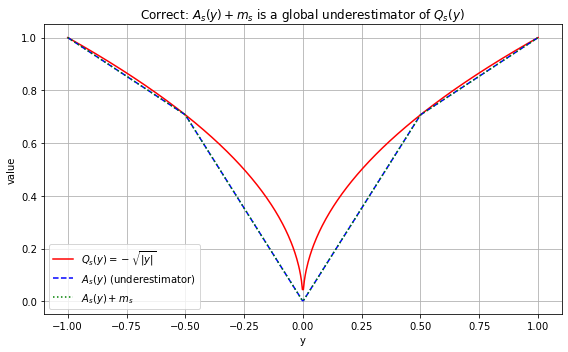

In [52]:
# y and z = |y|
y_vals = np.linspace(-1, 1, 500)
z_vals = np.abs(y_vals)

# define Qs(y)
Qs_vals2 = np.sqrt(z_vals)

# As(y)
y_nodes = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
z_nodes = abs(y_nodes)
as_nodes = np.sqrt(z_nodes)
As_vals2 = np.interp(z_vals, y_nodes, as_nodes)
As_shifted_vals2 = As_vals2 + m_s2

# make the plot
plt.figure(figsize=(8, 5))
plt.plot(y_vals, Qs_vals2, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, As_vals2, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
plt.plot(y_vals, As_shifted_vals2, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

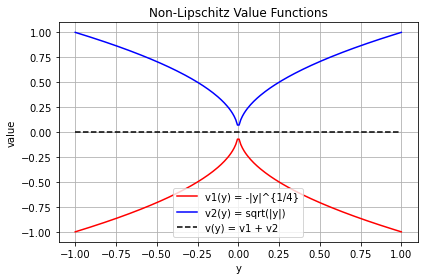

In [2]:
# first plot general diagram of v1(y), v2(y)
y_vals = np.linspace(-1, 1, 200)
v1_list, v2_list, v_total_list = [], [], []

# Initialize the solver
solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')

for y in y_vals:
    # Scenario 1：v1(y) = -|y|^{1/4}
    model1 = ConcreteModel()
    model1.x1 = Var(bounds=(0, 1))
    model1.obj = Objective(expr=-model1.x1, sense=minimize)
    model1.eq = Constraint(expr=model1.x1**4 == y**2)
    
    try:
        result1 = solver.solve(model1, tee=False)
        v1 = value(model1.obj)
    except:
        v1 = np.nan

    # Scenario 2：v2(y) = sqrt(|y|)
    model2 = ConcreteModel()
    model2.x2 = Var(bounds=(0, 1))
    model2.obj = Objective(expr=model2.x2, sense=minimize)
    model2.con1 = Constraint(expr=model2.x2**2 >= y)
    model2.con2 = Constraint(expr=model2.x2**2 >= -y)
    
    try:
        result2 = solver.solve(model2, tee=False)
        v2 = value(model2.obj)
    except:
        v2 = np.nan

    # combine v1 and v2 list
    v1_list.append(v1)
    v2_list.append(v2)
    if not np.isnan(v1) and not np.isnan(v2):
        v_total_list.append(v1 + v2)
    else:
        v_total_list.append(np.nan)

# plot
plt.plot(y_vals, v1_list, label="v1(y) = -|y|^{1/4}", color='red')
plt.plot(y_vals, v2_list, label="v2(y) = sqrt(|y|)", color='blue')
plt.plot(y_vals, v_total_list, label="v(y) = v1 + v2", linestyle='--', color='black')
plt.title("Non-Lipschitz Value Functions")
plt.xlabel("y")
plt.ylabel("value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
deltas = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
delta = 1e-1
n_samples = 5

# v1(y) = min -x_1

In [12]:
# define sampling nodes
#y_nodes = [-1.0, -0.5, 0.0, 0.5, 1.0]
y_nodes = np.linspace(-delta, delta, n_samples).tolist()
as_nodes = [-np.sqrt(abs(y)) for y in y_nodes]

# create model
model = ConcreteModel()
model.x1 = Var(bounds=(0, 1))
model.y = Var(bounds=(-delta, delta))

# define piecewise function
model.As = Var()
model.pw = Piecewise(
    model.As, model.y,
    pw_pts=y_nodes,
    f_rule=as_nodes,
    pw_constr_type='EQ',
    pw_repn='INC'
)

# set up constraint
model.eq = Constraint(expr=model.x1**4 == model.y**2)

# define objective function and solve the model
model.obj = Objective(expr= -model.x1 - model.As, sense=minimize)
solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
solver.solve(model)

# print the output
x1_opt = value(model.x1)
y_opt = value(model.y)
as_val = value(model.As)
m_s1 = value(model.obj)
print(f"x1 = {x1_opt:.4f}, y = {y_opt:.4f}, A_s(y) = {as_val:.4f}, m_s = {m_s1:.4f}")

x1 = 0.1109, y = -0.0123, A_s(y) = -0.0548, m_s = -0.0561


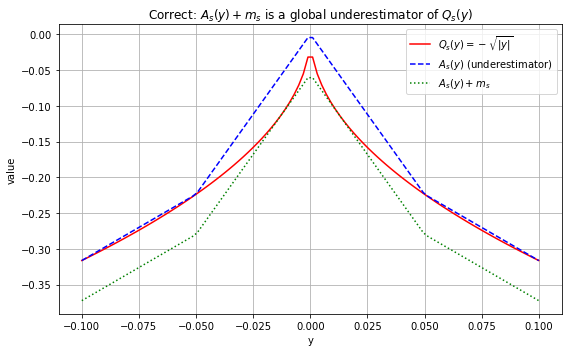

In [13]:
# y and z = |y|
y_vals = np.linspace(-delta, delta, 100)
z_vals = np.abs(y_vals)

# define Qs(y)
Qs_vals1 = -np.sqrt(z_vals)

# As(y)
y_nodes = np.array(y_nodes)
z_nodes = abs(y_nodes)
as_nodes = -np.sqrt(z_nodes)
As_vals1 = np.interp(z_vals, y_nodes, as_nodes)
# As + ms
As_shifted_vals1 = As_vals1 + m_s1

# make the plot
plt.figure(figsize=(8, 5))
plt.plot(y_vals, Qs_vals1, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, As_vals1, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
plt.plot(y_vals, As_shifted_vals1, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# v2 = min x_2

In [17]:
# define sampling nodes
y_nodes = np.linspace(-delta, delta, n_samples).tolist()
as_nodes = [np.sqrt(abs(y)) for y in y_nodes]


# define model
model = ConcreteModel()
model.x2 = Var(bounds=(0, 1))
model.y = Var(bounds=(-delta, delta))

# define piecewise function
model.As = Var()
model.pw = Piecewise(
    model.As, model.y,
    pw_pts=y_nodes,
    f_rule=as_nodes,
    pw_constr_type='EQ',
    pw_repn='INC'
)

# set up constraint
model.c1 = Constraint(expr=model.x2**2 >= model.y)
model.c2 = Constraint(expr=model.x2**2 >= -model.y)

# define objective function and solve the model
model.obj = Objective(expr=model.x2 - model.As, sense=minimize)
solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
solver.solve(model)

# print the output
x2_opt = value(model.x2)
y_opt = value(model.y)
as_val = value(model.As)
m_s2 = value(model.obj)
print(f"x2 = {x2_opt:.4f}, y = {y_opt:.4f}, A_s(y) = {as_val:.4f}, m_s = {m_s2:.4f}")

x2 = 0.2236, y = -0.0500, A_s(y) = 0.2236, m_s = -0.0000


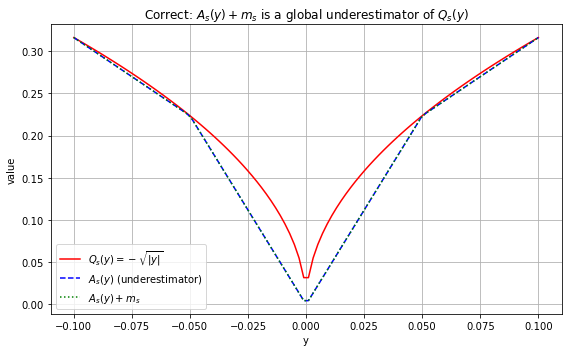

In [18]:
# y and z = |y|
y_vals = np.linspace(-delta, delta, 100)
z_vals = np.abs(y_vals)

# define Qs(y)
Qs_vals2 = np.sqrt(z_vals)

# As(y)
y_nodes = np.array(y_nodes)
z_nodes = abs(y_nodes)
as_nodes = np.sqrt(z_nodes)
As_vals2 = np.interp(z_vals, y_nodes, as_nodes)
As_shifted_vals2 = As_vals2 + m_s2

# make the plot
plt.figure(figsize=(8, 5))
plt.plot(y_vals, Qs_vals2, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, As_vals2, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
plt.plot(y_vals, As_shifted_vals2, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

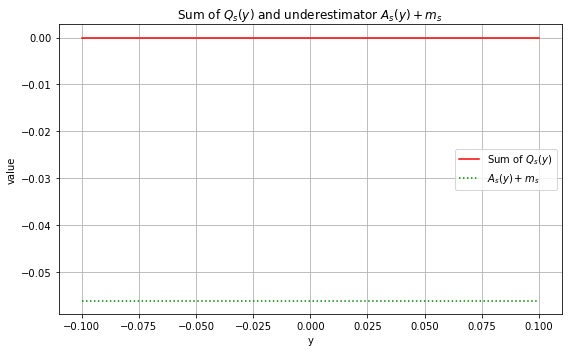

In [19]:
# make the plot
plt.figure(figsize=(8, 5))
plt.plot(y_vals, Qs_vals1+Qs_vals2, label=r'Sum of $Q_s(y)$', color='red')
plt.plot(y_vals, As_shifted_vals1+As_shifted_vals2, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Sum of $Q_s(y)$ and underestimator $A_s(y) + m_s$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# hausdorff error plot for 5 nodes 

/opt/anaconda3/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


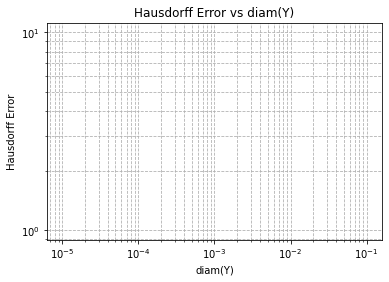

[(0.1, -0.3723079268387921), (0.01, -0.12482508918617341), (0.001, -0.053266520954561615), (0.0001, -0.02027725395893988), (1e-05, -0.009043349650483395)]


In [9]:
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

def compute_piecewise_hausdorff(delta, n_samples=5):
    #y_nodes = np.linspace(-delta, delta, n_samples)
    y_nodes = np.linspace(-delta, delta, n_samples).tolist()
    as1_nodes = [v_1(y) for y in y_nodes]
    as2_nodes = [v_2(y) for y in y_nodes]
    assum_nodes = as1_nodes + as2_nodes
    
    # create model for v1
    model1 = ConcreteModel()
    model1.x1 = Var(bounds=(0, 1))
    model1.y = Var(bounds=(-delta, delta))
    # define piecewise function
    model1.As = Var()
    model1.pw = Piecewise(
        model1.As, model1.y,
        pw_pts=y_nodes,
        f_rule=as1_nodes,
        pw_constr_type='EQ',
        pw_repn='INC'
    )
    # set up constraint
    model1.eq = Constraint(expr=model1.x1**4 == model1.y**2)
    # define objective function and solve the model
    model1.obj = Objective(expr= -model1.x1 - model1.As, sense=minimize)
    solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
    solver.solve(model1)
    # print the output
    as1_val = value(model1.As)
    m_s1 = value(model1.obj)
    
    
    
    # define model for v2
    model2 = ConcreteModel()
    model2.x2 = Var(bounds=(0, 1))
    model2.y = Var(bounds=(-delta, delta))
    # define piecewise function
    model2.As = Var()
    model2.pw = Piecewise(
        model2.As, model2.y,
        pw_pts=y_nodes,
        f_rule=as2_nodes,
        pw_constr_type='EQ',
        pw_repn='INC'
    )
    # set up constraint
    model2.c1 = Constraint(expr=model2.x2**2 >= model2.y)
    model2.c2 = Constraint(expr=model2.x2**2 >= -model2.y)
    # define objective function and solve the model
    model2.obj = Objective(expr=model2.x2 - model2.As, sense=minimize)
    solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
    solver.solve(model2)
    # print the output
    as2_val = value(model2.As)
    m_s2 = value(model2.obj)

    
    # output Hausdorff error
    #test_ys = np.linspace(-delta, delta, 100)
    #piecewise_interp = lambda y: np.interp(y, y_nodes, as_nodes)
    modelsum = ConcreteModel()
    modelsum.y = Var(bounds=(-delta, delta))
    # define piecewise function
    modelsum.As = Var()
    modelsum.pw = Piecewise(
        modelsum.As, modelsum.y,
        pw_pts=y_nodes,
        f_rule=assum_nodes,
        pw_constr_type='EQ',
        pw_repn='INC'
    )
    # set up constraint
    modelsum.obj = Objective(expr= modelsum.As, sense=minimize)
    solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
    solver.solve(modelsum)
    # print the output
    errors = value(modelsum.obj)+m_s1 + m_s2

    return delta, errors  # diameter, error

# make delta list
deltas = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
results = [compute_piecewise_hausdorff(d) for d in deltas]

# make the plot
diameters, errors = zip(*results)
plt.loglog(diameters, errors, marker='o', color='blue')
plt.xlabel("diam(Y)")
plt.ylabel("Hausdorff Error")
plt.title("Hausdorff Error vs diam(Y)")
plt.grid(True, which="both", ls="--")
plt.show()

print(results)

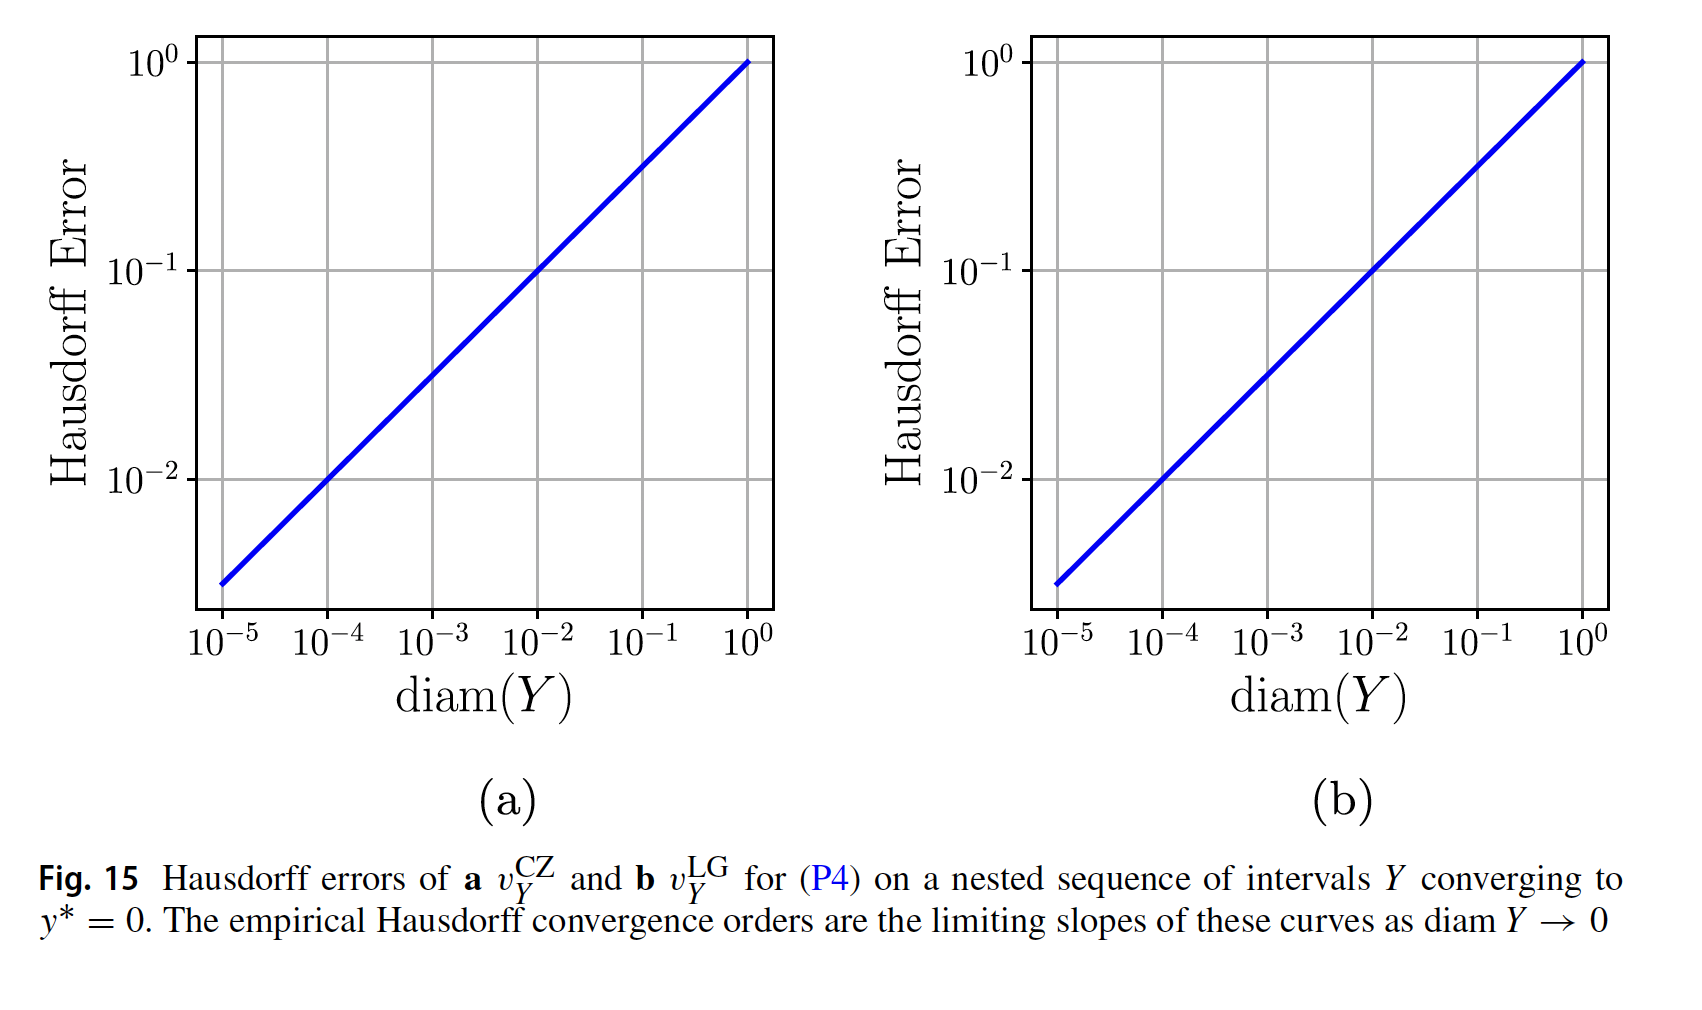

In [70]:
print(results)

[(0.1, 0.3162277854522382), (0.01, 0.10000026195524515), (0.001, 0.03092359654315482), (0.0001, 0.010241183441382048), (1e-05, 0.005759049208233985)]


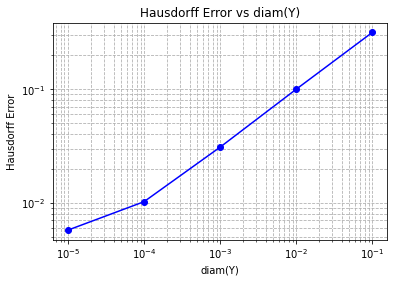

In [69]:
deltas = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
results = [compute_piecewise_hausdorff(d) for d in deltas]

# make the plot
diameters, errors = zip(*results)
plt.loglog(diameters, errors, marker='o', color='blue')
plt.xlabel("diam(Y)")
plt.ylabel("Hausdorff Error")
plt.title("Hausdorff Error vs diam(Y)")
plt.grid(True, which="both", ls="--")
plt.show()

# hausdorff error plot for 10 nodes 

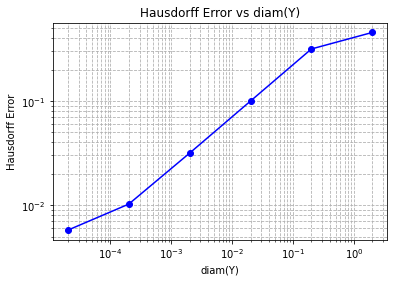

In [64]:
def compute_piecewise_hausdorff(delta, n_samples=10):
    y_nodes = np.linspace(-1, 1, 10).tolist()
    as1_nodes = [v_1(y) for y in y_nodes]
    as2_nodes = [v_2(y) for y in y_nodes]
    
    # create model for v1
    model1 = ConcreteModel()
    model1.x1 = Var(bounds=(0, 1))
    model1.y = Var(bounds=(-delta, delta))
    # define piecewise function
    model1.As = Var()
    model1.pw = Piecewise(
        model1.As, model1.y,
        pw_pts=y_nodes,
        f_rule=as1_nodes,
        pw_constr_type='EQ',
        pw_repn='INC'
    )
    # set up constraint
    model1.eq = Constraint(expr=model1.x1**4 == model1.y**2)
    # define objective function and solve the model
    model1.obj = Objective(expr= -model1.x1 - model1.As, sense=minimize)
    solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
    solver.solve(model1)
    # print the output
    as1_val = value(model1.As)
    m_s1 = value(model1.obj)
    
    
    # define mode for v2
    model2 = ConcreteModel()
    model2.x2 = Var(bounds=(0, 1))
    model2.y = Var(bounds=(-delta, delta))
    # define piecewise function
    model2.As = Var()
    model2.pw = Piecewise(
        model2.As, model2.y,
        pw_pts=y_nodes,
        f_rule=as2_nodes,
        pw_constr_type='EQ',
        pw_repn='INC'
    )
    # set up constraint
    model2.c1 = Constraint(expr=model2.x2**2 >= model2.y)
    model2.c2 = Constraint(expr=model2.x2**2 >= -model2.y)
    # define objective function and solve the model
    model2.obj = Objective(expr=model2.x2 - model2.As, sense=minimize)
    solver = SolverFactory('scip', executable='/Users/yinhuang/miniconda3/bin/scip')
    solver.solve(model2)
    # print the output
    as2_val = value(model2.As)
    m_s2 = value(model2.obj)

    # output Hausdorff error
    test_ys = np.linspace(-delta, delta, 100)
    piecewise_interp = lambda y: np.interp(y, y_nodes, as_nodes)
    errors = -(as1_val + m_s1 + as2_val + m_s2)

    return delta * 2, errors  # diameter, error

# make delta list
deltas = np.array([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
results = [compute_piecewise_hausdorff(d) for d in deltas]

# make the plot
diameters, errors = zip(*results)
plt.loglog(diameters, errors, marker='o', color='blue')
plt.xlabel("diam(Y)")
plt.ylabel("Hausdorff Error")
plt.title("Hausdorff Error vs diam(Y)")
plt.grid(True, which="both", ls="--")
plt.show()

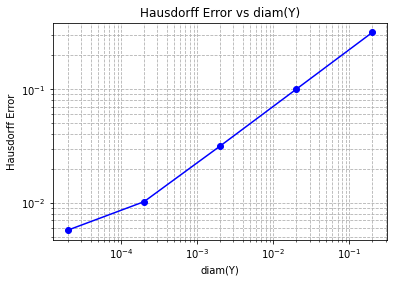

In [65]:
# make delta list
deltas = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
results = [compute_piecewise_hausdorff(d) for d in deltas]

# make the plot
diameters, errors = zip(*results)
plt.loglog(diameters, errors, marker='o', color='blue')
plt.xlabel("diam(Y)")
plt.ylabel("Hausdorff Error")
plt.title("Hausdorff Error vs diam(Y)")
plt.grid(True, which="both", ls="--")
plt.show()